In [1]:
import copy
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from utils.nn import FFNN

In [2]:
DATA = '../daily/data'
N_MODS = 3

Mutate: False


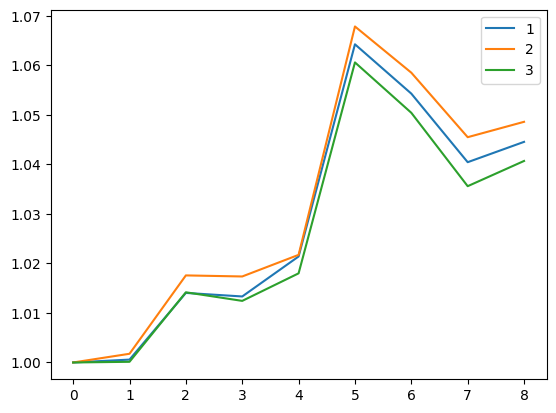

In [3]:
N_NEEDED = 9  # lengthen horizon only when best is the same as prev run

perf1 = np.array([103273,103333,104724,104650,105484,109910,108881,107451,107875])
perf2 = np.array([102405,102585,104206,104184,104631,109355,108399,107065,107383])
perf3 = np.array([102642,102656,104097,103919,104490,108863,107818,106297,106820])

MUTATE = len(perf1) - 1 >= N_NEEDED
print('Mutate:', MUTATE)

buying_power = [  1526,  3893,  1095]

plt.plot(perf1 / perf1[0], label='1')
plt.plot(perf2 / perf2[0], label='2')
plt.plot(perf3 / perf3[0], label='3')
plt.legend();

In [4]:
BEST = 2  # [1, 2, 3]
MUTATE_SCALE = 0.49005  # x0.9 or x1.1 decrease if same; incr if new

In [5]:
metrics = pd.read_csv(f'{DATA}/stock_metrics.csv')
metrics.head()

,stock,price,direction,RSI,RSIRev,fair_value_mult,geomean,sharpe
0,AAPL,196.250000,0,0.170000,0.830000,0.143198,0.088285,0.808589
1,ABNB,123.120003,1,0.602564,0.397436,0.668174,0.334012,0.170300
2,ACN,306.089996,1,0.503600,0.496400,0.787987,0.094561,0.652371
3,ADBE,384.970001,1,0.632000,0.368000,0.868735,0.108787,0.649662
4,AMD,100.360001,1,0.582400,0.417600,0.709626,0.210042,0.928246


In [6]:
x = metrics[['direction', 'RSI', 'fair_value_mult', 'geomean', 'sharpe']]

In [7]:
states = [None] * N_MODS
try:
    with open(f'{DATA}/ffnn_states.pkl', 'rb') as f:
        states = pickle.load(f)
        print('States recovered')
except FileNotFoundError:
    print('Creating new states...')
    states = [None] * N_MODS

States recovered


In [8]:
len(states)

3

In [9]:
mods = []
for state in states:
    mod = FFNN(**state) if state is not None else FFNN(5, [5])
    mods.append(mod)

In [10]:
if MUTATE:
    print('mutating...')
    best_state = mods[BEST - 1].get_state()
    mods = [mods[BEST - 1]]

    for _ in range(1, N_MODS):
        new_mod = FFNN(**copy.deepcopy(best_state))
        new_mod.mutate(scale=MUTATE_SCALE)
        mods.append(new_mod)
else:
    print('do nothing')

do nothing


In [11]:
len(mods)

3

In [12]:
#for mod in mods:
#    print(mod.Ws)

In [13]:
def get_holdings(filename, i):
    df = pd.read_csv(f'~/Downloads/ffnn/{filename}')
    df = df[['Symbol', 'Value']]
    df.Value = df.Value.str.replace('$', '').str.replace(',', '').astype(float)
    df.columns = ['stock', f'holdings{i + 1}']
    df.set_index('stock', drop=True, inplace=True)
    return df

In [14]:
holdings_files = sorted([f for f in os.listdir('/Users/damiansp/Downloads/ffnn') if f.endswith('.csv')])
holdings = pd.concat([get_holdings(f, i) for i, f in enumerate(holdings_files)], axis=1)
holdings.fillna(0, inplace=True)
holdings.head()

,holdings1,holdings2,holdings3
stock,,,
AAON,1052.81,478.55,1052.81
AAPL,1570.00,1766.25,785.00
ABBV,564.27,564.27,752.36
ABNB,615.60,1231.20,1108.08
ABT,535.80,0.00,0.00


In [15]:
out = pd.DataFrame({'stock': metrics.stock, 'price': metrics.price.round(2)})
cols = []
for i, mod in enumerate(mods):
    value = mod.forward_pass(x, 'relu', 'sigmoid')
    value = value.squeeze()
    value /= np.sum(value)
    col = pd.Series(value, name=f'val{i + 1}')
    cols.append(col)
out = pd.concat([out, *cols], axis=1)
out.head()

,stock,price,val1,val2,val3
0,AAPL,196.25,0.007700,0.010250,0.006912
1,ABNB,123.12,0.005031,0.005894,0.006158
2,ACN,306.09,0.006168,0.003676,0.006073
3,ADBE,384.97,0.005710,0.003096,0.006070
4,AMD,100.36,0.007458,0.005468,0.006762


In [16]:
for h in [1, 2, 3]:
    invested_amt = holdings[f'holdings{h}'].sum()
    buying_power[h - 1] += invested_amt
print(buying_power)
amt_in = []
for i, d in enumerate(buying_power):
    amt = (d * out[f'val{i + 1}']).round(2)
    amt_in.append(pd.Series(amt, name=f'amt{i + 1}'))
out = pd.concat([out, *amt_in], axis=1)
out.set_index('stock', inplace=True, drop=True)
out.head()

[215750.80000000002, 214766.93, 213640.47000000003]


,price,val1,val2,val3,amt1,amt2,amt3
stock,,,,,,,
AAPL,196.25,0.007700,0.010250,0.006912,1661.25,2201.35,1476.73
ABNB,123.12,0.005031,0.005894,0.006158,1085.53,1265.82,1315.63
ACN,306.09,0.006168,0.003676,0.006073,1330.81,789.48,1297.41
ADBE,384.97,0.005710,0.003096,0.006070,1231.93,664.93,1296.79
AMD,100.36,0.007458,0.005468,0.006762,1609.13,1174.24,1444.62


In [17]:
out = pd.concat([out, holdings], axis=1)
out.fillna(0, inplace=True)
out.head()

,price,val1,val2,val3,amt1,amt2,amt3,holdings1,holdings2,holdings3
stock,,,,,,,,,,
AAPL,196.25,0.007700,0.010250,0.006912,1661.25,2201.35,1476.73,1570.00,1766.25,785.00
ABNB,123.12,0.005031,0.005894,0.006158,1085.53,1265.82,1315.63,615.60,1231.20,1108.08
ACN,306.09,0.006168,0.003676,0.006073,1330.81,789.48,1297.41,918.27,918.27,918.27
ADBE,384.97,0.005710,0.003096,0.006070,1231.93,664.93,1296.79,1154.91,384.97,1154.91
AMD,100.36,0.007458,0.005468,0.006762,1609.13,1174.24,1444.62,1103.96,802.88,802.88


In [18]:
for i in range(N_MODS):
    out[f'diff{i + 1}'] = out[f'amt{i + 1}'] - out[f'holdings{i + 1}']
out.head()

,price,val1,val2,val3,amt1,amt2,amt3,holdings1,holdings2,holdings3,diff1,diff2,diff3
stock,,,,,,,,,,,,,
AAPL,196.25,0.007700,0.010250,0.006912,1661.25,2201.35,1476.73,1570.00,1766.25,785.00,91.25,435.10,691.73
ABNB,123.12,0.005031,0.005894,0.006158,1085.53,1265.82,1315.63,615.60,1231.20,1108.08,469.93,34.62,207.55
ACN,306.09,0.006168,0.003676,0.006073,1330.81,789.48,1297.41,918.27,918.27,918.27,412.54,-128.79,379.14
ADBE,384.97,0.005710,0.003096,0.006070,1231.93,664.93,1296.79,1154.91,384.97,1154.91,77.02,279.96,141.88
AMD,100.36,0.007458,0.005468,0.006762,1609.13,1174.24,1444.62,1103.96,802.88,802.88,505.17,371.36,641.74


In [19]:
out = out[((out.price.notnull()) & (out.price > 0))]

In [20]:
for i in range(N_MODS):
    out[f'shares{i + 1}'] = (out[f'diff{i + 1}'] / out.price).round().astype('Int64')
out = out[out.price >= 2]
out

,price,val1,val2,val3,amt1,amt2,amt3,holdings1,holdings2,holdings3,diff1,diff2,diff3,shares1,shares2,shares3
stock,,,,,,,,,,,,,,,,
AAPL,196.25,0.007700,0.010250,0.006912,1661.25,2201.35,1476.73,1570.00,1766.25,785.00,91.25,435.10,691.73,0,2,4
ABNB,123.12,0.005031,0.005894,0.006158,1085.53,1265.82,1315.63,615.60,1231.20,1108.08,469.93,34.62,207.55,4,0,2
ACN,306.09,0.006168,0.003676,0.006073,1330.81,789.48,1297.41,918.27,918.27,918.27,412.54,-128.79,379.14,1,0,1
ADBE,384.97,0.005710,0.003096,0.006070,1231.93,664.93,1296.79,1154.91,384.97,1154.91,77.02,279.96,141.88,0,1,0
AMD,100.36,0.007458,0.005468,0.006762,1609.13,1174.24,1444.62,1103.96,802.88,802.88,505.17,371.36,641.74,5,4,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VTRS,8.60,0.001583,0.003471,0.005087,341.48,745.41,1086.69,0.00,696.60,954.60,341.48,48.81,132.09,40,6,15
WING,270.16,0.006766,0.003527,0.006572,1459.66,757.43,1404.00,1080.64,1080.64,1080.64,379.02,-323.21,323.36,1,-1,1
WIT,2.90,0.003750,0.004837,0.005591,809.12,1038.84,1194.56,817.80,1197.70,855.50,-8.68,-158.86,339.06,-3,-55,117


<span style="color: red">CHECK URL!</span>

In [21]:
o = out.sort_values('diff1', ascending=False)[['price', 'diff1', 'shares1']]
o[o.shares1 != 0].head(5)

,price,diff1,shares1
stock,,,
RIVN,12.72,977.20,77
GOOG,152.80,897.53,6
BABA,123.23,828.85,7
CRWD,422.52,793.45,2
VRTX,434.82,789.05,2


In [22]:
o[o.shares1 != 0].tail(5)

,price,diff1,shares1
stock,,,
SMLR,33.05,-38.32,-1
CELH,35.79,-61.67,-2
WMT,98.83,-78.88,-1
NKE,58.62,-99.08,-2
GEHC,68.82,-275.06,-4


<span style="color: red">SERIOUSLY....</span></br>
<span style="color: red">CHECK URL!</span>

In [23]:
o = out.sort_values('diff2', ascending=False)[['price', 'diff2', 'shares2']]
o[o.shares2 != 0].head(5)

,price,diff2,shares2
stock,,,
MASI,150.11,1768.24,12
GOOG,152.80,1478.10,10
VRTX,434.82,1402.46,3
MRK,79.12,1273.71,16
GRAB,4.84,1222.76,253


In [24]:
o[o.shares2 != 0].tail(5)

,price,diff2,shares2
stock,,,
GLD,310.75,-389.62,-1
CB,290.43,-390.27,-1
NICE,160.44,-414.24,-3
DIS,102.09,-422.51,-4
GOLD,19.40,-467.20,-24


In [25]:
o = out.sort_values('diff3', ascending=False)[['price', 'diff3', 'shares3']]
o[o.shares3 != 0].head(5)

,price,diff3,shares3
stock,,,
V,349.85,700.76,2
BIDU,86.70,695.73,8
META,596.81,692.08,1
NLR,83.75,691.97,8
AAPL,196.25,691.73,4


In [26]:
o[o.shares3 != 0].tail(5)

,price,diff3,shares3
stock,,,
EQT,53.96,69.51,1
PATH,12.10,43.72,4
BROS,59.22,39.43,1
NVDA,117.06,-67.50,-1
GEHC,68.82,-131.20,-2


In [27]:
if MUTATE:
    states = [mod.get_state() for mod in mods]
    with open(f'{DATA}/ffnn_states.pkl', 'wb') as f:
        pickle.dump(states, f)
    print('States saved')
else:
    print('Did nothing')

Did nothing
